<a href="https://colab.research.google.com/github/geedoubledee/data620_project2/blob/main/DATA620_Project2_GDavis_BDavidoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA620: Project 2
#### by Glen Davis and Brett Davidoff

In [51]:
import math
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bi
import numpy as np
import pandas as pd
import random

## Introduction

We build a bimodal graph from [an edgelist of Marvel characters and comic books](http://konect.cc/networks/marvel/), [the accompanying labels for both kinds of nodes](https://bioinfo.uib.es/~joemiro/marvel.html), and [a key for transforming the shortened comic book labels into their proper titles](https://www.chronologyproject.com/key.php). An edge between a Marvel character node and comic book node means that character appeared in that comic book.

In [52]:
random.seed(12)
url1 = "https://raw.githubusercontent.com/geedoubledee/data620_project2/main/marvel_edgelist.txt"
edgelist = pd.read_csv(url1, header=None, skiprows=1, index_col=None, sep="\t")
edgelist.rename(columns={0: "n1", 1: "n2"}, inplace=True)
url2 = "https://raw.githubusercontent.com/geedoubledee/data620_project2/main/marvel_char_nodes.csv"
char_node_labs = pd.read_csv(url2, header=None, index_col=None)
char_node_labs = pd.DataFrame(char_node_labs.loc[:, 0].str.split(": ", n=1).to_list(), columns=["Node", "Char"])
char_node_labs["Node"] = pd.to_numeric(char_node_labs.loc[:, "Node"].str.replace("Vertex ", ""))
url3 = "https://raw.githubusercontent.com/geedoubledee/data620_project2/main/marvel_comic_nodes.csv"
comic_node_labs = pd.read_csv(url3, header=None, index_col=None)
comic_node_labs = pd.DataFrame(comic_node_labs.loc[:, 0].str.split(": ", n=1).to_list(), columns=["Node", "Comic"])
comic_node_labs["Node"] = pd.to_numeric(comic_node_labs.loc[:, "Node"].str.replace("Vertex ", ""))
url4 = "https://raw.githubusercontent.com/geedoubledee/data620_project2/main/marvel_comic_title_key.csv"
comic_lab_to_title = pd.read_csv(url4, index_col =None)
G = nx.from_pandas_edgelist(edgelist, "n1", "n2")
def concat(d1, d2):
    return {**d1, **d2}
char_nodes = char_node_labs.loc[:, "Node"].to_list()
comic_nodes = comic_node_labs.loc[:, "Node"].to_list()
bipartite_dict = concat(dict(zip(char_nodes, [0] * len(char_nodes))),
                        dict(zip(comic_nodes, [1] * len(comic_nodes))))
nx.set_node_attributes(G, bipartite_dict, name="bipartite")
name_dict = concat(pd.Series(char_node_labs.Char.values, index = char_node_labs.Node).to_dict(),
                    pd.Series(comic_node_labs.Comic.values, index = comic_node_labs.Node).to_dict())
nx.set_node_attributes(G, name_dict, name="name")
G_info = {"nodes": G.number_of_nodes(),
          "edges": G.size(),
          "diameter": "NA; Graph Not Connected"}
print(G_info)

{'nodes': 19428, 'edges': 96662, 'diameter': 'NA; Graph Not Connected'}


The bimodal graph has 19,428 nodes, 96,662 edges, and is unconnected, so it has no diameter. We reduce the graph to its largest connected component.

In [53]:
largest_cc = max(nx.connected_components(G), key=len)
S = G.subgraph(largest_cc)
S_info = {"nodes": S.number_of_nodes(),
          "edges": S.size(),
          "approx_diameter": nx.approximation.diameter(S)}
print(S_info)

{'nodes': 19365, 'edges': 96616, 'approx_diameter': 10}


The largest connected component is almost as large as the original graph. Since calculating its diameter exactly is computationally expensive, we settle for an approximation function. The approximate diameter of the subgraph is 10.

We project the bimodal graph onto the Marvel character nodes after first accounting for the fact that we have removed some nodes from the network.

In [54]:
char_nodes = {n for n, d in S.nodes(data=True) if d["bipartite"] == 0}
comic_nodes = set(S) - char_nodes
P = bi.weighted_projected_graph(S, char_nodes)
P_info = {"nodes": P.number_of_nodes(),
          "edges": P.size(),
          "approx_diameter": nx.approximation.diameter(P)}
print(P_info)

{'nodes': 6449, 'edges': 168211, 'approx_diameter': 5}


The projected graph has 6,449 nodes, 168,211 edges, and an approximate diameter of five. In the interest of splitting the graph into chunks we can actually analyze, we use the island method to find a number of smaller components with high concentrations of characters that are in the same comics. We consider 15 different edge weight thresholds on which to base the splits.

In [55]:
def trim_edges(g_orig, thresh = 1):
    names = nx.get_node_attributes(g_orig, "name")
    g_trim = nx.Graph()
    for src, to, edata in g_orig.edges(data=True):
        if edata["weight"] > thresh:
            g_trim.add_edge(src, to, weight = edata["weight"])
    nx.set_node_attributes(g_trim, names, name="name")
    return g_trim

def find_islands(g_orig, iters = 5):
    weights = [edata["weight"] for src, to, edata in g_orig.edges(data=True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx - mn)/iters)
    return [[thresh, trim_edges(g_orig, thresh)] for thresh in range(mn, mx, step)]
islands = find_islands(P, 15)
for i in islands:
    islands_list = sorted(nx.connected_components(i[1]), key = len, reverse = True)
    islands_dict = {"threshold": i[0],
                    "nodes": i[1].number_of_nodes(),
                    "islands": len(islands_list),
                    "largest_island": len(islands_list[0]),
                    "smallest_island": len(islands_list[-1])}
    print(islands_dict)

{'threshold': 1, 'nodes': 4562, 'islands': 11, 'largest_island': 4533, 'smallest_island': 2}
{'threshold': 50, 'nodes': 247, 'islands': 13, 'largest_island': 205, 'smallest_island': 2}
{'threshold': 99, 'nodes': 116, 'islands': 7, 'largest_island': 101, 'smallest_island': 2}
{'threshold': 148, 'nodes': 67, 'islands': 6, 'largest_island': 44, 'smallest_island': 2}
{'threshold': 197, 'nodes': 48, 'islands': 8, 'largest_island': 14, 'smallest_island': 2}
{'threshold': 246, 'nodes': 35, 'islands': 6, 'largest_island': 11, 'smallest_island': 2}
{'threshold': 295, 'nodes': 27, 'islands': 5, 'largest_island': 8, 'smallest_island': 4}
{'threshold': 344, 'nodes': 20, 'islands': 5, 'largest_island': 7, 'smallest_island': 2}
{'threshold': 393, 'nodes': 13, 'islands': 5, 'largest_island': 4, 'smallest_island': 2}
{'threshold': 442, 'nodes': 9, 'islands': 3, 'largest_island': 4, 'smallest_island': 2}
{'threshold': 491, 'nodes': 7, 'islands': 2, 'largest_island': 4, 'smallest_island': 3}
{'threshold

We see that using an edge weight threshold of 197 will produce a reduced graph with 48 nodes and eight islands. Visualizing these islands, we expect to be able to find teams of Marvel superheroes and the supervillain teams they're regularly up against. First, we take a look at all of the islands at once.

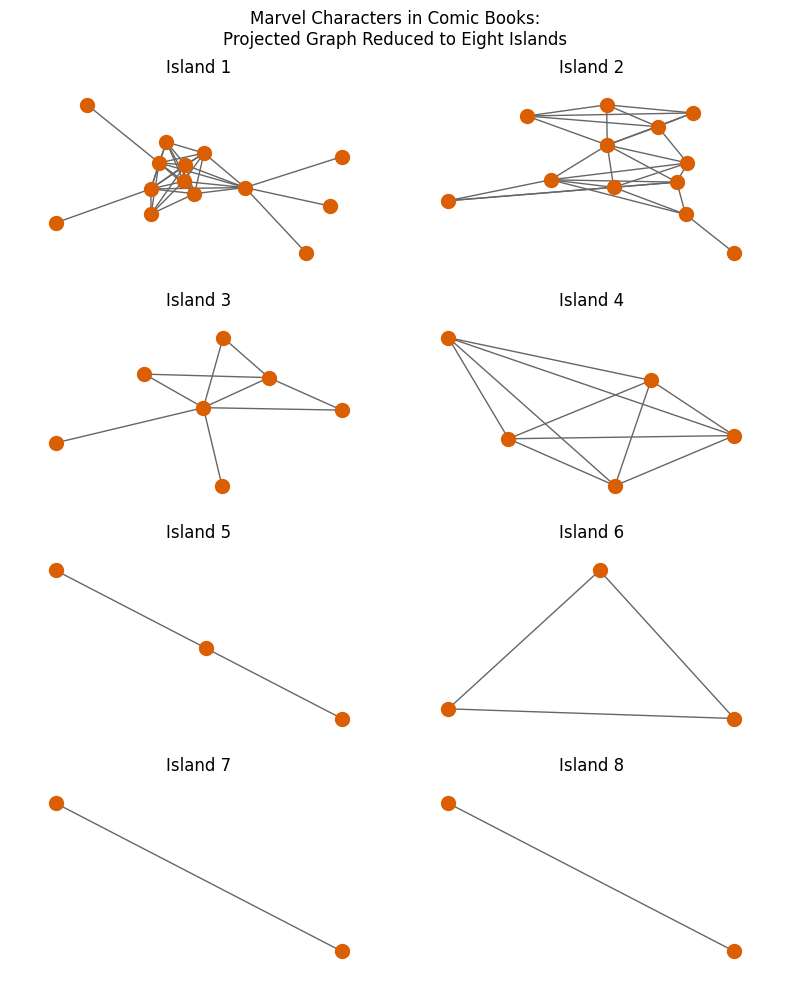

In [56]:
T = trim_edges(P, 197)
cc = [T.subgraph(c).copy() for c in sorted(nx.connected_components(T), key=len, reverse=True)]
fig, all_axes = plt.subplots(4, 2, figsize = (8, 10))
fig.suptitle("Marvel Characters in Comic Books:\nProjected Graph Reduced to Eight Islands")
ax = all_axes.flat
for i in range(len(cc)):
    c = cc[i]
    pos = nx.spring_layout(c)
    nx.draw(c, pos, ax=ax[i], node_color="#D95F02", node_size = 100, edge_color="#666666")
for i in range(len(ax)):
    a = ax[i]
    a.set_title(f"Island {i + 1}")
    a.margins(0.1)
fig.tight_layout()
plt.show()

Now we can take a closer look at some of the individual islands, starting with the largest: Island 1.

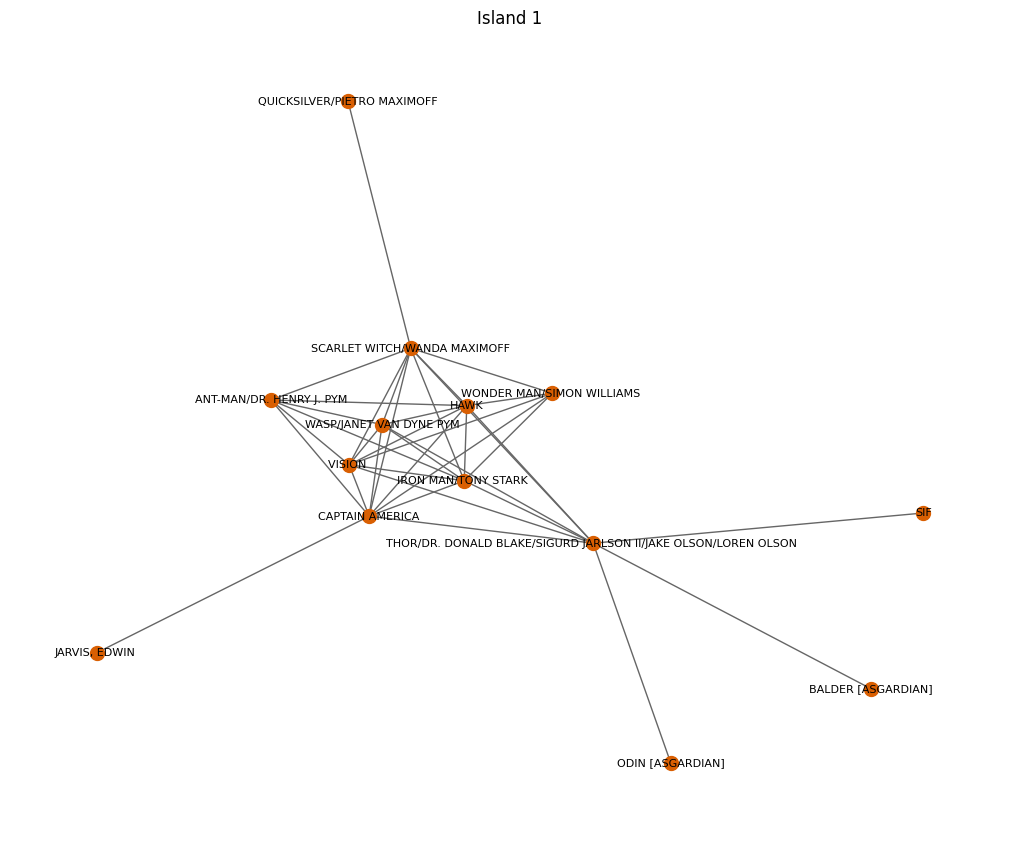

In [57]:
def plot_island(island, fig_sz=(10, 8), node_sz=100, font_sz=8,
                edge_col="#666666", node_col="#D95F02", label_nm="name",
                tit=""): # Function to plot an island with NetworkX/Matplotlib
    plt.figure(figsize=fig_sz)
    pos = nx.spring_layout(island)
    nx.draw(island, pos, with_labels=True,
            labels=nx.get_node_attributes(island, label_nm),
            node_size=node_sz, font_size=font_sz,
            edge_color=edge_col, node_color=node_col)
    plt.title(tit)
    plt.show()
i1 = cc[0]
plot_island(i1, tit="Island 1")

Not surprisingly, many of the Marvel characters on Island 1 are members of the Avengers. Iron Man's butler Edwin Jarvis even makes an appearance, but surprisingly he must appear in more comic books alongside Captain America than he does alongside Iron Man because Jarvis only shares an edge with Captain America.

We also see that Thor is a bridge spanner between the Avengers and the denizens of Asgard, his home.

Wonder Man's connection to the Avengers is interesting since he started out as a supervillain fighting against them, but later joined their team as a superhero. Wonder Man is also one of the only characters here who has not appeared in live action Marvel films or TV, but he will get his own series on Disney+ soon.

The last surprising thing to note is that Quicksilver is only connected to the rest of the Avengers through his sister Scarlet Witch despite the Avengers being his primary team. We did set the edge weight threshold pretty high though.

We calculate degree centrality and betweenness centrality for the Marvel characters on Island 1.

In [58]:
def calc_char_centrality(island, sort="Degree"):
    degree_centrality = round(pd.Series(nx.degree_centrality(island)).to_frame("Degree"), 3)
    betweenness_centrality = round(pd.Series(nx.betweenness_centrality(island)).to_frame("Between"), 3)
    centrality_df = degree_centrality.merge(betweenness_centrality, how="left", left_index=True, right_index=True)
    centrality_df.sort_values(by=sort, ascending=False, inplace=True)
    centrality_df.reset_index(inplace = True, names="Node")
    centrality_df = centrality_df.merge(char_node_labs, how="left", on="Node")
    centrality_df.drop(columns="Node", inplace=True)
    return centrality_df
top_5 = calc_char_centrality(i1).head(5)
print("\nTop 5 Characters by Degree Centrality: \n\n", top_5)


Top 5 Characters by Degree Centrality: 

    Degree  Between                                               Char
0   0.692    0.178                       SCARLET WITCH/WANDA MAXIMOFF
1   0.692    0.178                                    CAPTAIN AMERICA
2   0.692    0.423  THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE O...
3   0.615    0.024                               IRON MAN/TONY STARK 
4   0.615    0.024                                            VISION 


Scarlet Witch, Captain America, and Thor are all tied for the highest degree centrality.

In [59]:
top_5 = calc_char_centrality(i1, sort="Between").head(5)
print("\nTop 5 Characters by Betweenness Centrality: \n\n", top_5)


Top 5 Characters by Betweenness Centrality: 

    Degree  Between                                               Char
0   0.692    0.423  THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE O...
1   0.692    0.178                       SCARLET WITCH/WANDA MAXIMOFF
2   0.692    0.178                                    CAPTAIN AMERICA
3   0.615    0.024                               IRON MAN/TONY STARK 
4   0.615    0.024                                            VISION 


Thor has the highest betweenness centrality, which we assessed visually because of the bridge he establishes between the Avengers and the Asgardians.

Now let's take a look at Island 2.

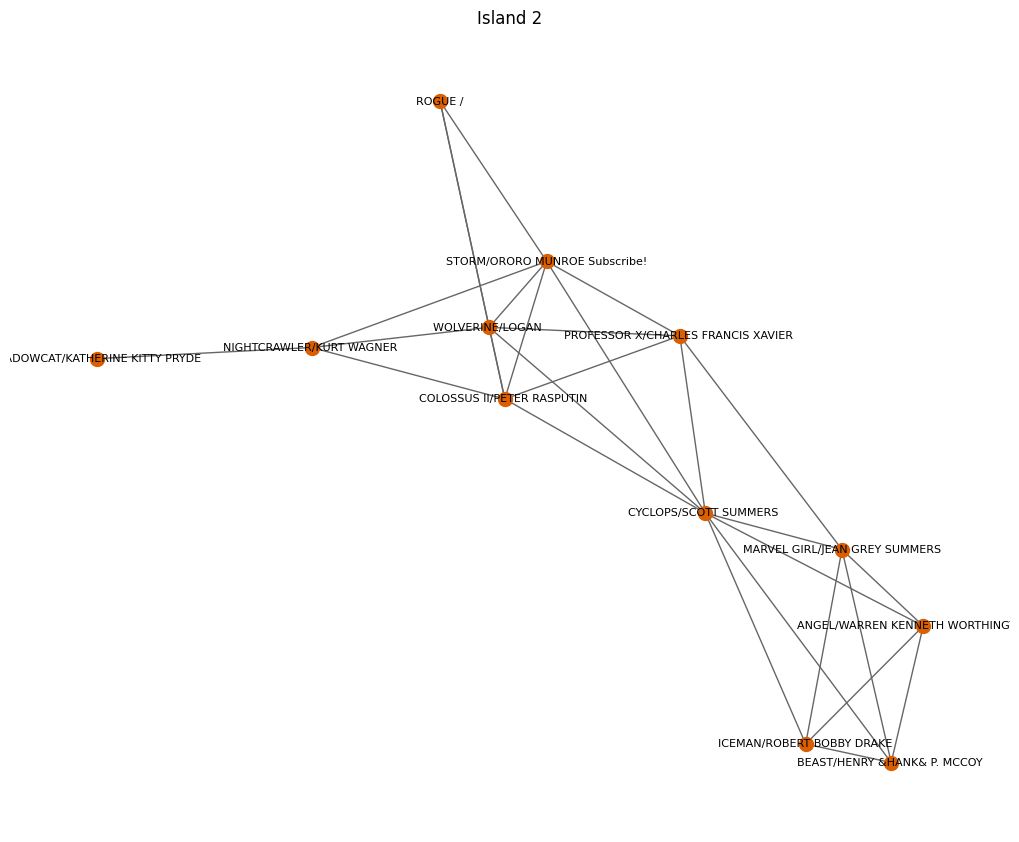

In [60]:
i2 = cc[1]
plot_island(i2, tit="Island 2")

Island 2 is comprised entirely of the X-Men, for whom Cyclops appears to be a bit of a bridge spanner. We calculate degree centrality and betweenness centrality for the Marvel characters on Island 2.

In [61]:
top_5 = calc_char_centrality(i2).head(5)
print("\nTop 5 Characters by Degree Centrality: \n\n", top_5)


Top 5 Characters by Degree Centrality: 

    Degree  Between                           Char
0   0.727    0.409         CYCLOPS/SCOTT SUMMERS 
1   0.545    0.121               WOLVERINE/LOGAN 
2   0.545    0.121    COLOSSUS II/PETER RASPUTIN 
3   0.545    0.121  STORM/ORORO MUNROE Subscribe!
4   0.455    0.027  MARVEL GIRL/JEAN GREY SUMMERS


Cyclops has the highest degree centrality.

In [62]:
top_5 = calc_char_centrality(i2, sort="Between").head(5)
print("\nTop 5 Characters by Betweenness Centrality: \n\n", top_5)


Top 5 Characters by Betweenness Centrality: 

    Degree  Between                           Char
0   0.727    0.409         CYCLOPS/SCOTT SUMMERS 
1   0.364    0.182      NIGHTCRAWLER/KURT WAGNER 
2   0.545    0.121               WOLVERINE/LOGAN 
3   0.545    0.121    COLOSSUS II/PETER RASPUTIN 
4   0.545    0.121  STORM/ORORO MUNROE Subscribe!


And he also has the highest betweenness centrality, so Cyclops is not only the most connected member of the X-Men; he is also the strongest connector between different groups within the team.

The lack of supervillain teams in both islands is a little surprising, so the edge weight threshold we set is too high to capture the adversarial relationships we expected to see. We lower the edge weight threshold and take another look at the largest island resulting from that to see if any adversarial or additional bridge spanner relationships appear.

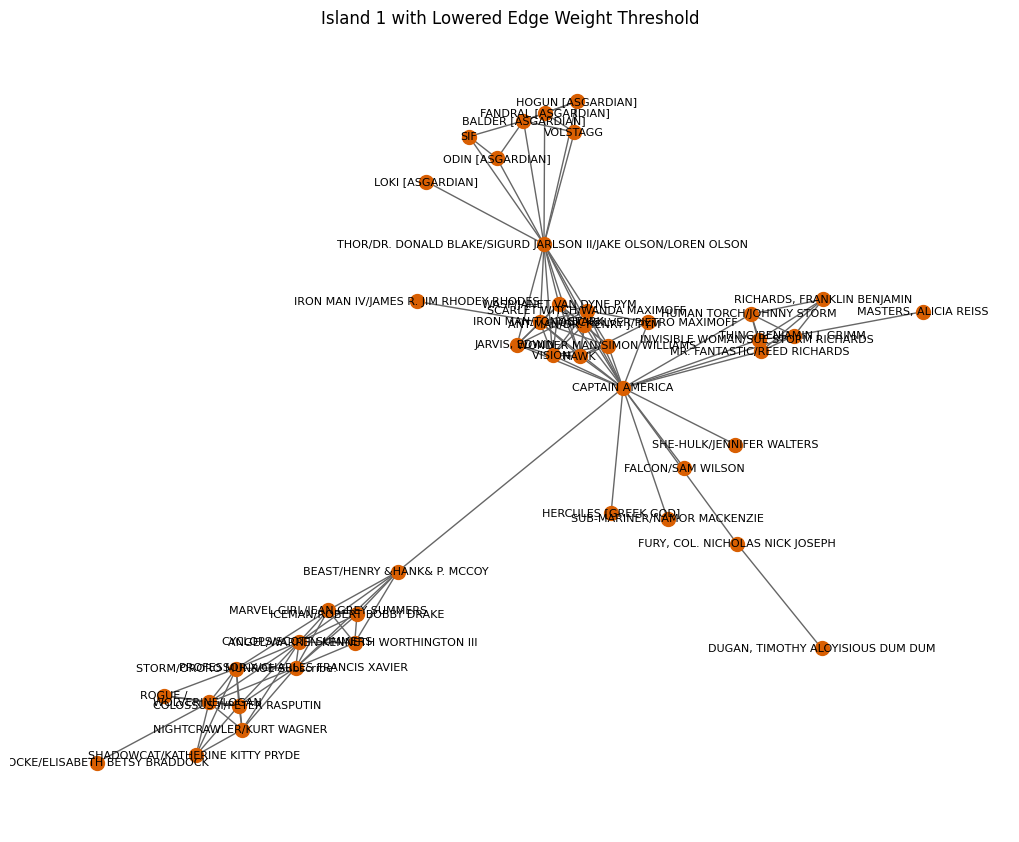

In [63]:
lower_thresh = 148 # Lower the threshold to include more characters on the largest island
T2 = trim_edges(P, lower_thresh) # Trim the edges of the graph with the new, lower threshold
cc2 = [T2.subgraph(c).copy() for c in sorted(nx.connected_components(T2), key=len, reverse=True)] # Identify new connected components with the lowered threshold
i1_new = cc2[0]
plot_island(i1_new, tit="Island 1 with Lowered Edge Weight Threshold")


We don't immediately recognize any supervillain teams, but we can now see more interactions between different superhero teams. Lowering the edge weight threshold revealed that Captain America is a bridge spanner between not only the Avengers and the X-Men, but also between the Avengers and the Fantastic Four.

We calculate degree centrality and betweenness centrality for the Marvel characters on this island.

In [64]:
top_5 = calc_char_centrality(i1_new).head(5)
print("\nTop 5 Characters by Degree Centrality: \n\n", top_5)


Top 5 Characters by Degree Centrality: 

    Degree  Between                                               Char
0   0.465    0.734                                    CAPTAIN AMERICA
1   0.349    0.289  THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE O...
2   0.233    0.008                       SCARLET WITCH/WANDA MAXIMOFF
3   0.233    0.048                               IRON MAN/TONY STARK 
4   0.209    0.002                            WASP/JANET VAN DYNE PYM


Captain American has the highest degree centrality.

In [65]:
top_5 = calc_char_centrality(i1_new, sort="Between").head(5)
print("\nTop 5 Characters by Betweenness Centrality: \n\n", top_5)


Top 5 Characters by Betweenness Centrality: 

    Degree  Between                                               Char
0   0.465    0.734                                    CAPTAIN AMERICA
1   0.140    0.412                       BEAST/HENRY &HANK& P. MCCOY 
2   0.349    0.289  THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE O...
3   0.209    0.122                             CYCLOPS/SCOTT SUMMERS 
4   0.209    0.122                PROFESSOR X/CHARLES FRANCIS XAVIER 


And he also has the highest betweenness centrality. So Captain America is both the most connected Marvel character and the strongest connector between different Marvel teams. Beast is another stand-out character, acting as Captain America's link to the rest of the X-Men.

Finally, we look for any exceptionally connected cliques among the already very connected characters in this island.

In [66]:
cliq_thresh = 0.5 * max(list(nx.get_edge_attributes(i1_new, "weight").values()))
i1_new2 = trim_edges(i1_new, thresh = cliq_thresh)
cliques = sorted(nx.find_cliques(i1_new2), key=len, reverse=True)
print("\nPotential Cliques in Island 1 with Lowered Edge Weight Treshold:\n")
for cliq in cliques:
    chars = []
    for node in cliq:
        chars.append(char_node_labs[char_node_labs["Node"] == node].Char.values[0])
    print(chars)


Potential Cliques in Island 1 with Lowered Edge Weight Treshold:

['HUMAN TORCH/JOHNNY STORM ', 'INVISIBLE WOMAN/SUE STORM RICHARDS ', 'THING/BENJAMIN J. GRIMM ', 'MR. FANTASTIC/REED RICHARDS ']
['CAPTAIN AMERICA', 'SCARLET WITCH/WANDA MAXIMOFF', 'VISION ']
['WOLVERINE/LOGAN ', 'STORM/ORORO MUNROE Subscribe!']
['CAPTAIN AMERICA', 'THOR/DR. DONALD BLAKE/SIGURD JARLSON II/JAKE OLSON/LOREN OLSON ']
['CAPTAIN AMERICA', 'WASP/JANET VAN DYNE PYM']
['CAPTAIN AMERICA', 'IRON MAN/TONY STARK ']
['MARVEL GIRL/JEAN GREY SUMMERS', 'CYCLOPS/SCOTT SUMMERS ']
['ANT-MAN/DR. HENRY J. PYM', 'WASP/JANET VAN DYNE PYM']


We have identified the Fantastic Four as one stand-out clique, as well as Wolverine and Storm of the X-Men, Jean Grey and Cyclops of the X-Men, Ant-Man and Wasp of the Avengers, and several Avengers cliques featuring Captain America, who not only links three large and important superhero teams, but also has strong ties within the core of his own team.